In [ ]:
pip install maticalgos py_vollib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.4 MB/s eta 0:00:00
  Created wheel for maticalgos: filename=maticalgos-0.70-py3-none-any.whl size=2507 sha256=c35feba00d42a127f584211e612bfee7e8822b133fc175be8866e51f8cb0078c
  Stored in directory: /root/.cache/pip/wheels/96/a0/b2/a124839415aa858d6e0ac1e991327070e2070b96143dd16574
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=0bbc9b37db2e9bd76ebd501c53686e0568170e0d2e2ed77bd6e1dff5828b1758
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha25

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta
import datetime
from datetime import timedelta

In [ ]:
from maticalgos.historical import historical

#ma = historical('sohamjain91@gmail.com')
ma = historical('aotleviackerman317@gmail.com')

In [ ]:
#ma.login("853494")
ma.login("101652")

#Terminator


In [ ]:
import datetime

data = ma.get_data("banknifty", datetime.date(2019,5,2))

In [ ]:
data

NameError: ignored

In [ ]:
data['symbol'] = data['symbol'].astype('string')
data['expiry_date'] = [symbol[9:16] for symbol in data['symbol']]
data['strike_price'] = [symbol[16:-2] for symbol in data['symbol']]
data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
data['expiry_date'] = data['expiry_date'].astype('string')
data['close'] = data['close'].astype('float')

data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
data_bnf = data_bnf.set_index(data_bnf.Datetime)
data_bnf = data_bnf['close']
data_bnf = data_bnf.to_frame()
data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
data['Datetime'] = data['date'] + ' ' + data['time']
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index(data.Datetime)

data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
data = data.join(data_bnf, how='inner')

data['strike_price'] = data['strike_price'].astype('float')

In [ ]:
data1 = data.copy()
data1 = data1[(data1['CE_PE'] == 'CE') & (data1.index.time == datetime.time(14, 59))]

data1['dist_100'] = (100 - data1['close']).abs()
data1 = data1.sort_values(by = 'dist_100', ascending = True)

In [ ]:
data2 = data.copy()
data2 = data2[(data2['CE_PE'] == 'PE') & (data2.index.time == datetime.time(14, 59))]

data2['dist_100'] = (100 - data2['close']).abs()
data2 = data2.sort_values(by = 'dist_100', ascending = True)

In [ ]:
ce_sp = data1['strike_price'].head(1)[0]
pe_sp = data2['strike_price'].head(1)[0]

ce_sp, pe_sp

(43600.0, 43200.0)

In [ ]:
call_df = data[(data['CE_PE'] == 'CE') & (data['strike_price'] == ce_sp) & (data.index.time >= datetime.time(14, 59))]
put_df = data[(data['CE_PE'] == 'PE') & (data['strike_price'] == pe_sp) & (data.index.time >= datetime.time(14, 59))]

In [ ]:
call_order_limit = call_df.close[0] * 0.9
put_order_limit = put_df.close[0] * 0.9

call_order_limit, put_order_limit

(88.56, 85.77)

In [ ]:
call_order_sl = call_df.close[0] * 1.25
put_order_sl = put_df.close[0] * 1.25

call_order_sl, put_order_sl

(123.0, 119.125)

In [ ]:
trade = False
trading_cost = 14
call_signal = []
put_signal = []

profit = []

for i in range(1, len(call_df)):

  if ((call_df['close'][i] < call_order_limit) and (call_df['close'][i-1] > 90)):

    Buy_price = call_df['close'][i]
    Buy_index = i

    for j in range(i, len(call_df)):

        if (call_df['close'][j] > call_order_sl):

            call_signal.append([
                'Entry Time: {}'.format(call_df.index[i]), 'Exit Time: {}'.format(call_df.index[j]),"Direction: CE", 'Strike Price: {}'.format(ce_sp),
                'Limit Order: {}'.format(call_order_limit), 'SL: {}'.format(call_order_sl),
                'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(call_df['close'][j]),
                'Profit Per Lot: {}'.format(((Buy_price - call_df['close'][j]) * 25)-trading_cost)
            ])

            profit.append([call_df.index[i], (((Buy_price - call_df['close'][j]) * 25)-trading_cost)])

            break

        elif j == (len(call_df) - 3):
            call_signal.append([
                'Entry Time: {}'.format(call_df.index[i]), 'Exit Time: {}'.format(call_df.index[j]), 'Strike Price: {}'.format(ce_sp),
                'Limit Order: {}'.format(call_order_limit), 'SL: {}'.format(call_order_sl),
                'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(call_df['close'][-3]),
                'Profit Per Lot: {}'.format(((Buy_price - call_df['close'][-3]) * 25)-trading_cost)
            ])

            profit.append([call_df.index[i], (((Buy_price - call_df['close'][j]) * 25)-trading_cost)])

            break

    break


  elif ((put_df['close'][i] < put_order_limit) and (put_df['close'][i-1] > 90)):

        Buy_price = put_df['close'][i]
        Buy_index = i

        for j in range(i, len(put_df)):

          if (put_df['close'][j] > put_order_sl):

            put_signal.append([
                'Entry Time: {}'.format(call_df.index[i]), 'Exit Time: {}'.format(call_df.index[j]), 'Strike Price: {}'.format(pe_sp),
                'Limit Order: {}'.format(put_order_limit), 'SL: {}'.format(put_order_sl),
                'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(put_df['close'][j]),
                'Profit Per Lot: {}'.format(((Buy_price - put_df['close'][j])*25)-trading_cost)
            ])

            profit.append([put_df.index[i], (((Buy_price - put_df['close'][j]) * 25)-trading_cost)])

            break

          elif j == (len(put_df) - 3):
            put_signal.append([
                'Entry Time: {}'.format(put_df.index[i]), 'Exit Time: {}'.format(put_df.index[j]), "Direction: PE", 'Strike Price: {}'.format(pe_sp),
                'Limit Order: {}'.format(put_order_limit), 'SL: {}'.format(put_order_sl),
                'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(put_df['close'][-3]),
                'Profit Per Lot: {}'.format(((Buy_price - put_df['close'][-3]) * 25)-trading_cost)
            ])

            profit.append([put_df.index[i], (((Buy_price - put_df['close'][j]) * 25)-14)])

            break

        break

In [ ]:
call_signal

[['Entry Time: 2023-05-02 15:07:00',
  'Exit Time: 2023-05-02 15:27:00',
  'Strike Price: 43600.0',
  'Limit Order: 88.56',
  'SL: 123.0',
  'Buy Price: 86.35',
  'Sell Price: 77.3',
  'Profit Per Lot: 212.24999999999994']]

In [ ]:
put_signal

[]

In [ ]:
profit

[[Timestamp('2023-05-02 15:07:00'), 212.24999999999994]]

In [ ]:
start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2023, 6, 1)
current_date = start_date
trading_cost = 14

trade = False
call_signal = []
put_signal = []
profit = []

while current_date <= end_date:
    try:
      data = ma.get_data("banknifty", current_date)
      data['symbol'] = data['symbol'].astype('string')
      data['expiry_date'] = [symbol[9:16] for symbol in data['symbol']]
      data['strike_price'] = [symbol[16:-2] for symbol in data['symbol']]
      data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
      data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
      data['expiry_date'] = data['expiry_date'].astype('string')
      data['close'] = data['close'].astype('float')

      data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
      data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
      data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
      data_bnf = data_bnf.set_index(data_bnf.Datetime)
      data_bnf = data_bnf['close']
      data_bnf = data_bnf.to_frame()
      data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

      data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
      data['Datetime'] = data['date'] + ' ' + data['time']
      data['Datetime'] = pd.to_datetime(data['Datetime'])
      data = data.set_index(data.Datetime)

      data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
      data = data.join(data_bnf, how='inner')

      data['strike_price'] = data['strike_price'].astype('float')
      data1 = data.copy()
      data1 = data1[(data1['CE_PE'] == 'CE') & (data1.index.time == datetime.time(14, 59))]

      data1['dist_100'] = (100 - data1['close']).abs()
      data1 = data1.sort_values(by = 'dist_100', ascending = True)

      data2 = data.copy()
      data2 = data2[(data2['CE_PE'] == 'PE') & (data2.index.time == datetime.time(14, 59))]

      data2['dist_100'] = (100 - data2['close']).abs()
      data2 = data2.sort_values(by = 'dist_100', ascending = True)

      ce_sp = data1['strike_price'].head(1)[0]
      pe_sp = data2['strike_price'].head(1)[0]

      call_df = data[(data['CE_PE'] == 'CE') & (data['strike_price'] == ce_sp) & (data.index.time >= datetime.time(14, 59))]
      put_df = data[(data['CE_PE'] == 'PE') & (data['strike_price'] == pe_sp) & (data.index.time >= datetime.time(14, 59))]

      call_order_limit = call_df.close[0] * 0.9
      put_order_limit = put_df.close[0] * 0.9

      call_order_sl = call_df.close[0] * 1.25
      put_order_sl = put_df.close[0] * 1.25

      for i in range(1, len(call_df)):

        if ((call_df['close'][i] < call_order_limit) and (call_df['close'][i-1] > 90)):

          Buy_price = call_df['close'][i]
          Buy_index = i

          for j in range(i, len(call_df)):

              if (call_df['close'][j] > call_order_sl):

                  call_signal.append([
                      'Entry Time: {}'.format(call_df.index[i]), 'Exit Time: {}'.format(call_df.index[j]),"Direction: CE", 'Strike Price: {}'.format(ce_sp),
                      'Limit Order: {}'.format(call_order_limit), 'SL: {}'.format(call_order_sl),
                      'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(call_df['close'][j]),
                      'Profit Per Lot: {}'.format(((Buy_price - call_df['close'][j]) * 25)-trading_cost)
                  ])

                  profit.append([call_df.index[i], (((Buy_price - call_df['close'][j]) * 25)-trading_cost)])

                  break

              elif j == (len(call_df) - 3):
                  call_signal.append([
                      'Entry Time: {}'.format(call_df.index[i]), 'Exit Time: {}'.format(call_df.index[j]), 'Strike Price: {}'.format(ce_sp),
                      'Limit Order: {}'.format(call_order_limit), 'SL: {}'.format(call_order_sl),
                      'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(call_df['close'][-3]),
                      'Profit Per Lot: {}'.format(((Buy_price - call_df['close'][-3]) * 25)-trading_cost)
                  ])

                  profit.append([call_df.index[i], (((Buy_price - call_df['close'][j]) * 25)-trading_cost)])

                  break

          break


        elif ((put_df['close'][i] < put_order_limit) and (put_df['close'][i-1] > 90)):

              Buy_price = put_df['close'][i]
              Buy_index = i

              for j in range(i, len(put_df)):

                if (put_df['close'][j] > put_order_sl):

                  put_signal.append([
                      'Entry Time: {}'.format(call_df.index[i]), 'Exit Time: {}'.format(call_df.index[j]), 'Strike Price: {}'.format(pe_sp),
                      'Limit Order: {}'.format(put_order_limit), 'SL: {}'.format(put_order_sl),
                      'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(put_df['close'][j]),
                      'Profit Per Lot: {}'.format((Buy_price - put_df['close'][j])*25)
                  ])

                  profit.append([put_df.index[i], (((Buy_price - put_df['close'][j]) * 25)-trading_cost)])

                  break

                elif j == (len(put_df) - 3):
                  put_signal.append([
                      'Entry Time: {}'.format(put_df.index[i]), 'Exit Time: {}'.format(put_df.index[j]), "Direction: PE", 'Strike Price: {}'.format(pe_sp),
                      'Limit Order: {}'.format(put_order_limit), 'SL: {}'.format(put_order_sl),
                      'Buy Price: {}'.format(Buy_price), 'Sell Price: {}'.format(put_df['close'][-3]),
                      'Profit Per Lot: {}'.format(((Buy_price - put_df['close'][-3]) * 25)-trading_cost)
                  ])

                  profit.append([put_df.index[i], (((Buy_price - put_df['close'][j]) * 25)-trading_cost)])

                  break

              break

        # Process the data or perform desired operations
    except Exception as e:
        print("Error occurred for date", current_date)
        # Optionally, you can choose to ignore the error and continue without any specific handling
        pass

    current_date += datetime.timedelta(days=1)

In [ ]:
profit_df = pd.DataFrame(profit)
profit_df = profit_df.rename(columns = {0 : 'Date', 1: 'Daily_profit'})
profit_df.index = profit_df.Date
profit_df['Total_profits'] = np.cumsum(profit_df['Daily_profit'])

In [ ]:
profit_df['Day'] = profit_df.index.day_name()
profit_df = profit_df[profit_df['Day'] != 'Saturday']
profit_df_day = profit_df.copy()
profit_df_day = profit_df_day.groupby(by = 'Day').mean()

In [ ]:
profit_df_day['Daily_profit'].to_frame()

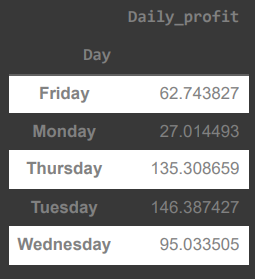

In [ ]:
profit_df_day.index = profit_df_day.index.astype('string')

([<matplotlib.axis.XTick at 0x7f92bc27c3d0>,
 [Text(0, 0, 'Friday'),
  Text(1, 0, 'Monday'),
  Text(2, 0, 'Thursday'),
  Text(3, 0, 'Tuesday'),
  Text(4, 0, 'Wednesday')])

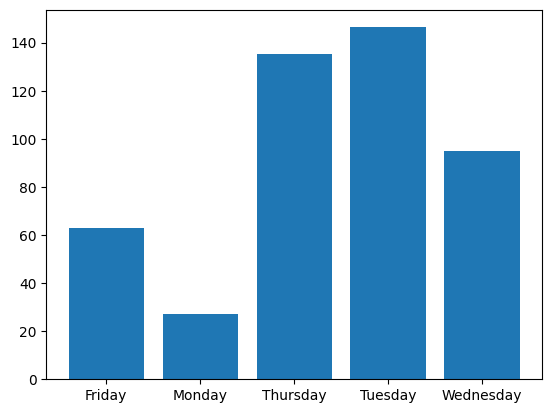

In [ ]:
plt.bar(range(len(profit_df_day)),profit_df_day['Daily_profit'])      #standard deviation of returns
plt.xticks(range(len(profit_df_day)),profit_df_day.index)

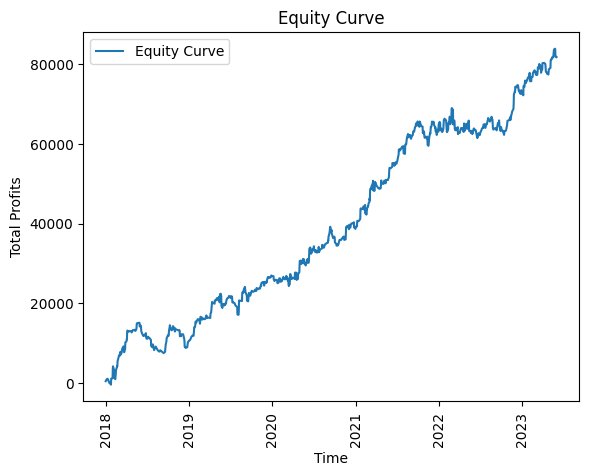

In [ ]:
import matplotlib.pyplot as plt

plt.plot(profit_df['Total_profits'])
plt.xlabel('Time')
plt.xticks(rotation = 90)
plt.ylabel('Total Profits')
plt.title('Equity Curve')
plt.legend(['Equity Curve'])
plt.show()

In [ ]:
profit_monthly_df = profit_df.resample('M').sum()

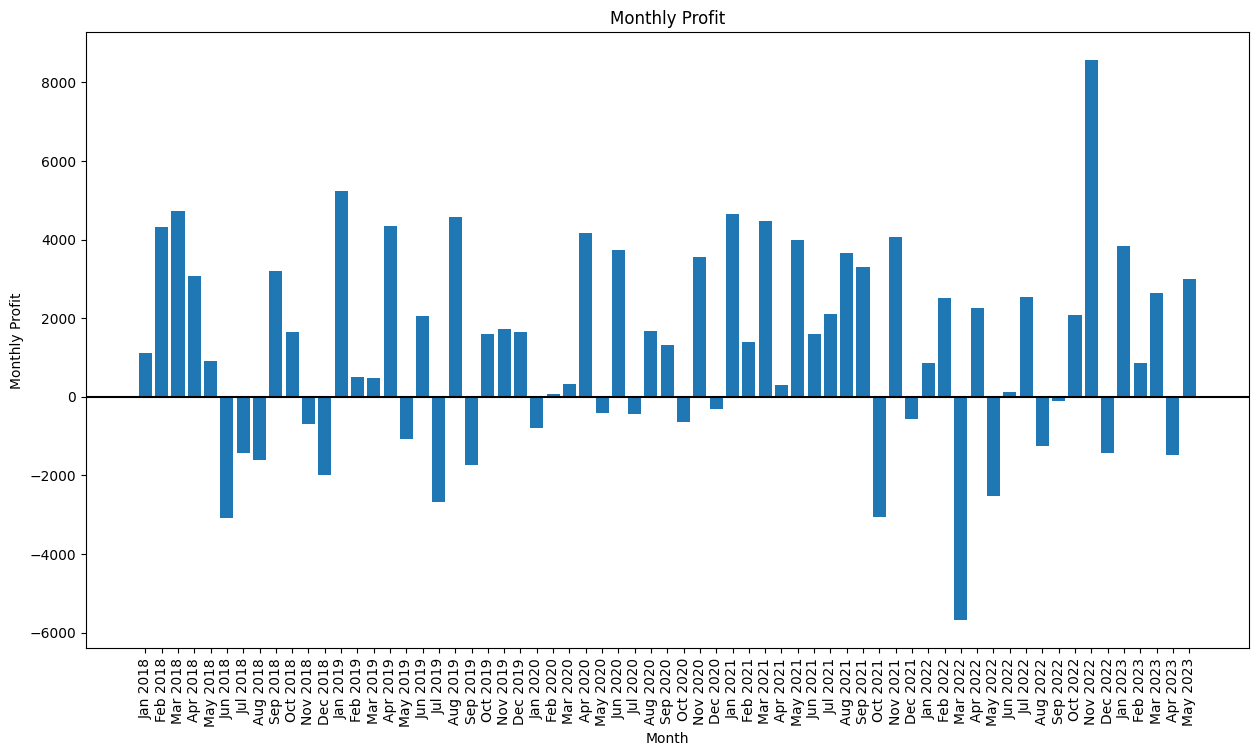

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.bar(range(len(profit_monthly_df['Daily_profit'])), profit_monthly_df['Daily_profit'])
plt.xticks(range(len(profit_monthly_df['Daily_profit'])), profit_monthly_df.index.strftime('%b %Y'), rotation = 90)
plt.axhline(y=0, color = 'black')
plt.xlabel('Month')
plt.ylabel('Monthly Profit')
plt.title('Monthly Profit')
plt.show()

In [ ]:
profit_quarter_df = profit_df.resample('q').sum()

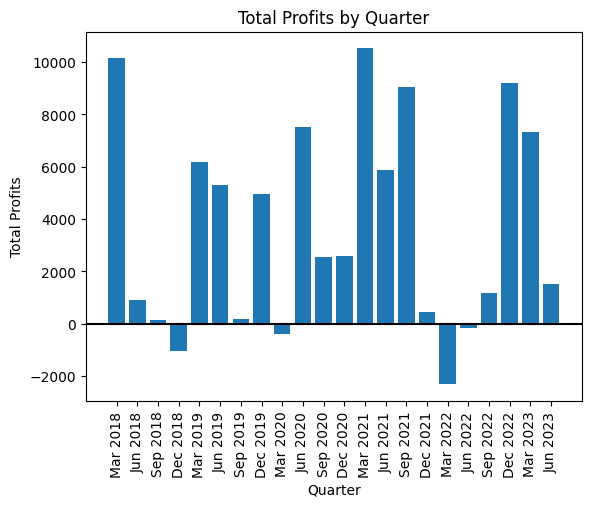

In [ ]:
plt.bar(range(len(profit_quarter_df['Daily_profit'])), profit_quarter_df['Daily_profit'])
plt.xticks(range(len(profit_quarter_df['Daily_profit'])), profit_quarter_df.index.strftime('%b %Y'), rotation = 90)
plt.axhline(y=0, color='black')

plt.xlabel('Quarter')
plt.ylabel('Total Profits')
plt.title('Total Profits by Quarter')
plt.show()

In [ ]:
cost = []
for i in range(1,50):
  trading_cost  = (15*i + 40)/i
  cost.append(trading_cost)

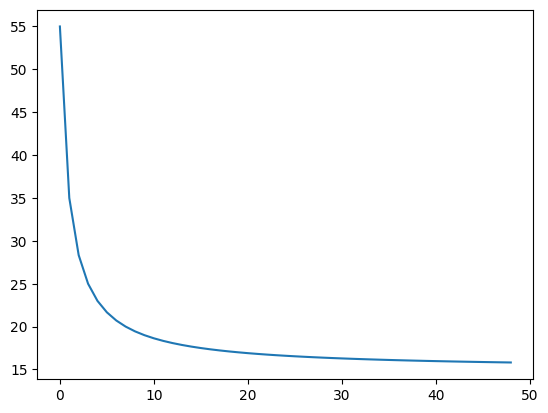

In [ ]:
plt.plot(cost)

#Straddle

In [ ]:
data = ma.get_data("banknifty", datetime.date(2023,5,25))

In [ ]:
data['symbol'] = data['symbol'].astype('string')
data['expiry_date'] = [symbol[9:16] for symbol in data['symbol']]
data['strike_price'] = [symbol[16:-2] for symbol in data['symbol']]
data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
data['expiry_date'] = data['expiry_date'].astype('string')
data['close'] = data['close'].astype('float')

data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
data_bnf = data_bnf.set_index(data_bnf.Datetime)
data_bnf = data_bnf['close']
data_bnf = data_bnf.to_frame()
data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
data['Datetime'] = data['date'] + ' ' + data['time']
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index(data.Datetime)

data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
data = data.join(data_bnf, how='inner')

data['strike_price'] = data['strike_price'].astype('float')
data['expiry_date'] = pd.to_datetime(data['expiry_date'] + ' ' + '15:30:00')
data['time_to_expiry'] = data['expiry_date'] - data.index
data['time_to_expiry'] = data['time_to_expiry']/timedelta(days = 365)
data['ATM'] = round(data['bnf_close']/100)*100
data['CE_PE'] = data['CE_PE'].apply(lambda x : 'p' if x == 'PE' else 'c')

In [ ]:
rs = data.loc[datetime.time(9,20)]

In [ ]:
rs = rs[rs['CE_PE'] == 'c']
rs = rs.sort_values('strike_price')

In [ ]:
implied_volatility(rs['close'][20], rs['bnf_close'][20], rs['strike_price'][20], rs['time_to_expiry'][20], 0.1, rs['CE_PE'][20])

0.2596416014417103

In [ ]:
iv = []
for i in range(len(rs)):
    try:
        c = implied_volatility(rs['close'][i], rs['bnf_close'][i], rs['strike_price'][i], rs['time_to_expiry'][i], 0.1, rs['CE_PE'][i])
        iv.append([rs['strike_price'][i], c])
    except Exception as e:
        # Handle the specific exception that occurred
        # You can choose to skip the iteration silently or print an error message
        # Here, we simply print the error message and continue to the next iteration
        print(f"Error occurred in iteration {rs['strike_price'][i]}: {e}")
        continue

Error occurred in iteration 40000.0: The volatility is below the intrinsic value.
Error occurred in iteration 41500.0: The volatility is below the intrinsic value.
Error occurred in iteration 42000.0: The volatility is below the intrinsic value.


In [ ]:
iv = pd.DataFrame(iv)

In [ ]:
iv.head()

,0,1
0,35000.0,3.510622
1,38000.0,2.264379
2,39000.0,2.009325
3,41000.0,1.067492
4,42500.0,0.452293


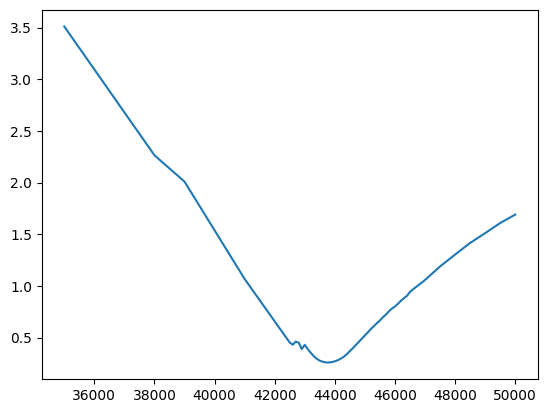

In [ ]:
plt.plot(iv[0], iv[1])

In [ ]:
shift_time = datetime.time(9, 20)
end_time = datetime.time(14, 45)

In [ ]:
data_straddle = data.loc[shift_time]
data_straddle = data_straddle[data_straddle['strike_price'] == data_straddle['ATM']]

In [ ]:
data_straddle

,close,expiry_date,strike_price,CE_PE,bnf_close,time_to_expiry,ATM
Datetime,,,,,,,
2023-05-25 12:52:00,56.2,2023-05-25 15:30:00,43600.0,c,43550.35,0.000301,43600.0
2023-05-25 12:52:00,100.9,2023-05-25 15:30:00,43600.0,p,43550.35,0.000301,43600.0


In [ ]:
straddle_strike_price = data_straddle['strike_price'][0]

In [ ]:
straddle_strike_price

43600.0

In [ ]:
straddle_price = data[data['strike_price'] == data_straddle['strike_price'][0]]

In [ ]:
iv = []
for i in range(len(straddle_price)):
    try:
        c = implied_volatility(straddle_price['close'][i], straddle_price['bnf_close'][i], straddle_price['strike_price'][i], straddle_price['time_to_expiry'][i], 0.1, straddle_price['CE_PE'][i])
        iv.append(c)
    except Exception as e:
        print(f"Error occurred in iteration {straddle_price['strike_price'][i]} {straddle_price.index[i]}: {e}")
        iv.append(None)  # Append a placeholder value (e.g., None) to indicate an error
        continue

straddle_price['IV'] = iv

Error occurred in iteration 43600.0 2023-05-25 15:08:00: The volatility is below the intrinsic value.
Error occurred in iteration 43600.0 2023-05-25 15:15:00: The volatility is below the intrinsic value.
Error occurred in iteration 43600.0 2023-05-25 15:16:00: The volatility is below the intrinsic value.
Error occurred in iteration 43600.0 2023-05-25 15:18:00: The volatility is below the intrinsic value.
Error occurred in iteration 43600.0 2023-05-25 15:19:00: The volatility is below the intrinsic value.


In [ ]:
delt = []
for i in range(len(straddle_price)):
  d = delta(straddle_price['CE_PE'][i], straddle_price['bnf_close'][i], straddle_price['strike_price'][i], straddle_price['time_to_expiry'][i] , 0.1, straddle_price['IV'][i])
  delt.append(d)
straddle_price['Delta'] = delt

In [ ]:
straddle_price

,close,expiry_date,strike_price,CE_PE,bnf_close,time_to_expiry,ATM,IV,Delta
Datetime,,,,,,,,,
2023-05-25 09:15:00,148.10,2023-05-25 15:30:00,43600.0,c,43656.75,0.000713,43700.0,0.248906,0.583050
2023-05-25 09:15:00,94.90,2023-05-25 15:30:00,43600.0,p,43656.75,0.000713,43700.0,0.263525,-0.421347
2023-05-25 09:16:00,138.75,2023-05-25 15:30:00,43600.0,c,43614.65,0.000712,43600.0,0.279456,0.523261
2023-05-25 09:16:00,100.00,2023-05-25 15:30:00,43600.0,p,43614.65,0.000712,43600.0,0.234126,-0.472770
2023-05-25 09:17:00,146.65,2023-05-25 15:30:00,43600.0,c,43641.70,0.000710,43600.0,0.265239,0.559172
...,...,...,...,...,...,...,...,...,...
2023-05-25 15:27:00,0.05,2023-05-25 15:30:00,43600.0,p,43665.50,0.000006,43700.0,0.250024,-0.005962
2023-05-25 15:28:00,81.55,2023-05-25 15:30:00,43600.0,c,43668.95,0.000004,43700.0,1.100596,0.769521
2023-05-25 15:28:00,0.05,2023-05-25 15:30:00,43600.0,p,43668.95,0.000004,43700.0,0.320430,-0.005720


In [ ]:
straddle_price[straddle_price['IV'].isna()]

,close,expiry_date,strike_price,CE_PE,bnf_close,time_to_expiry,ATM,IV,Delta
Datetime,,,,,,,,,
2023-05-25 15:08:00,98.20,2023-05-25 15:30:00,43600.0,c,43705.35,0.000042,43700.0,NaN,NaN
2023-05-25 15:15:00,97.75,2023-05-25 15:30:00,43600.0,c,43714.75,0.000029,43700.0,NaN,NaN
2023-05-25 15:16:00,95.15,2023-05-25 15:30:00,43600.0,c,43699.65,0.000027,43700.0,NaN,NaN
2023-05-25 15:18:00,91.20,2023-05-25 15:30:00,43600.0,c,43699.30,0.000023,43700.0,NaN,NaN
2023-05-25 15:19:00,87.10,2023-05-25 15:30:00,43600.0,c,43696.20,0.000021,43700.0,NaN,NaN


In [ ]:
deltas_ce = straddle_price[straddle_price['CE_PE'] == 'c']['Delta']
deltas_pe = straddle_price[straddle_price['CE_PE'] == 'p']['Delta']
deltas = deltas_ce + deltas_pe
deltas = deltas.to_frame()
deltas = deltas.abs()

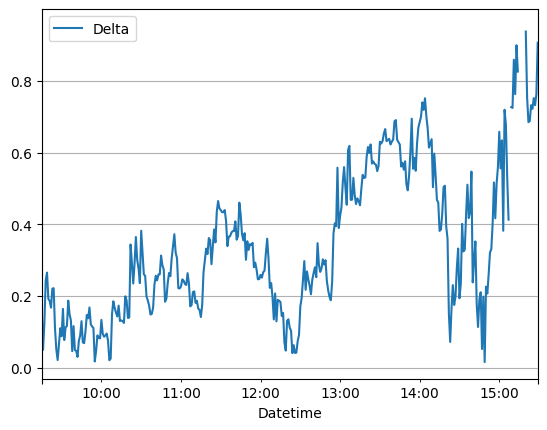

In [ ]:
deltas.plot()
plt.grid()

In [ ]:
for i in range(len(deltas)):
  if deltas.iloc[i][0] > 0.2:
    if ((deltas.iloc[i].name.time() > shift_time) & (deltas.iloc[i].name.time() < end_time)):
      shift_time = deltas.index[i].time()
      break

In [ ]:
shift_time

datetime.time(12, 54)

In [ ]:
data_straddle

,close,expiry_date,strike_price,CE_PE,bnf_close,time_to_expiry,ATM
Datetime,,,,,,,
2023-05-25 12:10:00,63.95,2023-05-25 15:30:00,43600.0,c,43561.55,0.000381,43600.0
2023-05-25 12:10:00,108.75,2023-05-25 15:30:00,43600.0,p,43561.55,0.000381,43600.0


In [ ]:
data_straddle[data_straddle['CE_PE']=='c'].strike_price[0]

43700.0

In [ ]:
trade_open = []
trade_close = []


data = ma.get_data("banknifty", datetime.date(2023,5,24))

data['symbol'] = data['symbol'].astype('string')
data['expiry_date'] = [symbol[9:16] for symbol in data['symbol']]
data['strike_price'] = [symbol[16:-2] for symbol in data['symbol']]
data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
data['expiry_date'] = data['expiry_date'].astype('string')
data['close'] = data['close'].astype('float')

data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
data_bnf = data_bnf.set_index(data_bnf.Datetime)
data_bnf = data_bnf['close']
data_bnf = data_bnf.to_frame()
data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
data['Datetime'] = data['date'] + ' ' + data['time']
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index(data.Datetime)

data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
data = data.join(data_bnf, how='inner')

data['strike_price'] = data['strike_price'].astype('float')
data['expiry_date'] = pd.to_datetime(data['expiry_date'] + ' ' + '15:30:00')
data['time_to_expiry'] = data['expiry_date'] - data.index
data['time_to_expiry'] = data['time_to_expiry']/timedelta(days = 365)
data['ATM'] = round(data['bnf_close']/100)*100
data['CE_PE'] = data['CE_PE'].apply(lambda x : 'p' if x == 'PE' else 'c')

shift_time = datetime.time(9, 20)
end_time = datetime.time(14, 45)

for i in range(10):

  data_straddle = data.loc[shift_time]

  data_straddle = data_straddle[data_straddle['strike_price'] == data_straddle['ATM']]

  straddle_price = data[data['strike_price'] == data_straddle['strike_price'][0]]

  sp = data_straddle[data_straddle['CE_PE']=='c'].strike_price[0]

  trade_open.append([data_straddle[data_straddle['CE_PE']=='c'].close[0], data_straddle[data_straddle['CE_PE']=='p'].close[0], sp, data_straddle.index[0]])

  iv = []
  for k in range(len(straddle_price)):
    try:
      c = implied_volatility(straddle_price['close'][k], straddle_price['bnf_close'][k], straddle_price['strike_price'][k], straddle_price['time_to_expiry'][k], 0.1, straddle_price['CE_PE'][k])
      iv.append(c)
    except Exception as e:
        iv.append(None)
        continue

  straddle_price['IV'] = iv

  delt = []
  for l in range(len(straddle_price)):
    d = delta(straddle_price['CE_PE'][l], straddle_price['bnf_close'][l], straddle_price['strike_price'][l], straddle_price['time_to_expiry'][l] , 0.1, straddle_price['IV'][l])
    delt.append(d)
  straddle_price['Delta'] = delt

  deltas_ce = straddle_price[straddle_price['CE_PE'] == 'c']['Delta']
  deltas_pe = straddle_price[straddle_price['CE_PE'] == 'p']['Delta']
  deltas = deltas_ce + deltas_pe
  deltas = deltas.to_frame()
  deltas = deltas.abs()



  for j in range(len(deltas)):
    if deltas.iloc[j][0] > 0.2:
      if ((deltas.iloc[j].name.time() > shift_time) & (deltas.iloc[j].name.time() < end_time)):
        shift_time = deltas.index[j].time()
        break
    if (deltas.iloc[j].name.time() > end_time):
      shift_time = end_time


  print(shift_time)

  data_straddle_close = data.loc[shift_time]
  data_straddle_close = data_straddle_close[data_straddle_close['strike_price'] == sp]
  trade_close.append([data_straddle_close[data_straddle_close['CE_PE']=='c'].close[0], data_straddle_close[data_straddle_close['CE_PE']=='p'].close[0], sp, data_straddle_close.index[0]])

09:49:00
10:52:00
12:05:00
13:12:00
14:45:00
14:45:00
14:45:00
14:45:00
14:45:00
14:45:00


In [ ]:
profit_df = pd.DataFrame(trade_open)-pd.DataFrame(trade_close)
profit_df = profit_df.iloc[:,[0,1]]
profit_df['total'] = profit_df.iloc[:,0] + profit_df.iloc[:,1]

In [ ]:
trade_open, trade_close

([[157.25, 176.2, 43800.0, Timestamp('2023-05-24 09:20:00')],
  [160.6, 164.55, 43900.0, Timestamp('2023-05-24 09:49:00')],
  [147.85, 166.2, 44000.0, Timestamp('2023-05-24 10:52:00')],
  [150.75, 161.7, 43900.0, Timestamp('2023-05-24 12:05:00')],
  [145.0, 154.15, 43800.0, Timestamp('2023-05-24 13:12:00')],
  [145.0, 135.2, 43700.0, Timestamp('2023-05-24 14:45:00')],
  [145.0, 135.2, 43700.0, Timestamp('2023-05-24 14:45:00')],
  [145.0, 135.2, 43700.0, Timestamp('2023-05-24 14:45:00')],
  [145.0, 135.2, 43700.0, Timestamp('2023-05-24 14:45:00')],
  [145.0, 135.2, 43700.0, Timestamp('2023-05-24 14:45:00')]],
 [[216.9, 120.6, 43800.0, Timestamp('2023-05-24 09:49:00')],
  [203.3, 121.2, 43900.0, Timestamp('2023-05-24 10:52:00')],
  [105.05, 216.5, 44000.0, Timestamp('2023-05-24 12:05:00')],
  [100.0, 209.35, 43900.0, Timestamp('2023-05-24 13:12:00')],
  [98.55, 188.5, 43800.0, Timestamp('2023-05-24 14:45:00')],
  [145.0, 135.2, 43700.0, Timestamp('2023-05-24 14:45:00')],
  [145.0, 135.2,

In [ ]:
profit_df

,0,1,total
0,-59.65,55.60,-4.05
1,-42.70,43.35,0.65
2,42.80,-50.30,-7.50
3,50.75,-47.65,3.10
4,46.45,-34.35,12.10
5,0.00,0.00,0.00
6,0.00,0.00,0.00
7,0.00,0.00,0.00
8,0.00,0.00,0.00
9,0.00,0.00,0.00


In [ ]:
profit_df.total.sum()*25

107.49999999999922

#Overall backtest of straddle

In [ ]:
start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2023, 6, 1)
current_date = start_date

profit = []
pnl_date = []

while current_date <= end_date:
    try:

        trade_open = []
        trade_close = []

        data = ma.get_data("banknifty", current_date)

        data['symbol'] = data['symbol'].astype('string')
        data['expiry_date'] = [symbol[9:16] for symbol in data['symbol']]
        data['strike_price'] = [symbol[16:-2] for symbol in data['symbol']]
        data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
        data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
        data['expiry_date'] = data['expiry_date'].astype('string')
        data['close'] = data['close'].astype('float')

        data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
        data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
        data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
        data_bnf = data_bnf.set_index(data_bnf.Datetime)
        data_bnf = data_bnf['close']
        data_bnf = data_bnf.to_frame()
        data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

        data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
        data['Datetime'] = data['date'] + ' ' + data['time']
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        data = data.set_index(data.Datetime)

        data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
        data = data.join(data_bnf, how='inner')

        data['strike_price'] = data['strike_price'].astype('float')
        data['expiry_date'] = pd.to_datetime(data['expiry_date'] + ' ' + '15:30:00')
        data['time_to_expiry'] = data['expiry_date'] - data.index
        data['time_to_expiry'] = data['time_to_expiry']/timedelta(days = 365)
        data['ATM'] = round(data['bnf_close']/100)*100
        data['CE_PE'] = data['CE_PE'].apply(lambda x : 'p' if x == 'PE' else 'c')

        shift_time = datetime.time(9, 20)
        end_time = datetime.time(14, 45)

        for i in range(10):

          data_straddle = data.loc[shift_time]

          data_straddle = data_straddle[data_straddle['strike_price'] == data_straddle['ATM']]

          straddle_price = data[data['strike_price'] == data_straddle['strike_price'][0]]

          sp = data_straddle[data_straddle['CE_PE']=='c'].strike_price[0]

          trade_open.append([data_straddle[data_straddle['CE_PE']=='c'].close[0], data_straddle[data_straddle['CE_PE']=='p'].close[0], sp, data_straddle.index[0]])

          iv = []
          for k in range(len(straddle_price)):
            try:
              c = implied_volatility(straddle_price['close'][k], straddle_price['bnf_close'][k], straddle_price['strike_price'][k], straddle_price['time_to_expiry'][k], 0.1, straddle_price['CE_PE'][k])
              iv.append(c)

            except Exception as e:
              iv.append(None)
              continue

          straddle_price['IV'] = iv

          delt = []
          for l in range(len(straddle_price)):
            d = delta(straddle_price['CE_PE'][l], straddle_price['bnf_close'][l], straddle_price['strike_price'][l], straddle_price['time_to_expiry'][l] , 0.1, straddle_price['IV'][l])
            delt.append(d)
          straddle_price['Delta'] = delt

          deltas_ce = straddle_price[straddle_price['CE_PE'] == 'c']['Delta']
          deltas_pe = straddle_price[straddle_price['CE_PE'] == 'p']['Delta']
          deltas = deltas_ce + deltas_pe
          deltas = deltas.to_frame()
          deltas = deltas.abs()

          for j in range(len(deltas)):
            if deltas.iloc[j][0] > 0.2:
              if ((deltas.iloc[j].name.time() > shift_time) & (deltas.iloc[j].name.time() < end_time)):
                shift_time = deltas.index[j].time()
                break
            if (deltas.iloc[j].name.time() > end_time):
              shift_time = end_time

          data_straddle_close = data.loc[shift_time]
          data_straddle_close = data_straddle_close[data_straddle_close['strike_price'] == sp]
          trade_close.append([data_straddle_close[data_straddle_close['CE_PE']=='c'].close[0], data_straddle_close[data_straddle_close['CE_PE']=='p'].close[0], sp, data_straddle_close.index[0]])

        profit_df = pd.DataFrame(trade_open)-pd.DataFrame(trade_close)
        profit_df = profit_df.iloc[:,[0,1]]
        profit_df['total'] = profit_df.iloc[:,0] + profit_df.iloc[:,1]

        profit.append(profit_df.total.sum()*25)
        pnl_date.append(current_date)

    except Exception as e:

        #print("Error occurred for date", current_date)
        pass

    current_date += datetime.timedelta(days=1)

In [ ]:
pnl = pd.DataFrame(profit, index = pnl_date, columns = ['PnL'])
pnl.index = pd.to_datetime(pnl.index)
pnl['Day'] = pnl.index.day_name()
pnl = pnl[pnl['Day'] != 'Thursday']
pnl = pnl[pnl['Day'] != 'Saturday']
pnl['Cum_profit'] = pnl['PnL'].cumsum()

In [ ]:
pnl

,PnL,Day,Cum_profit
2019-03-01,651.25,Friday,651.25
2019-03-05,45.00,Tuesday,696.25
2019-03-06,68.75,Wednesday,765.00
2019-03-08,305.00,Friday,1070.00
2019-03-11,218.75,Monday,1288.75
...,...,...,...
2023-05-24,107.50,Wednesday,377927.50
2023-05-26,103.75,Friday,378031.25
2023-05-29,1212.50,Monday,379243.75
2023-05-30,1271.25,Tuesday,380515.00


In [ ]:
pnl.to_csv('pnl.csv')

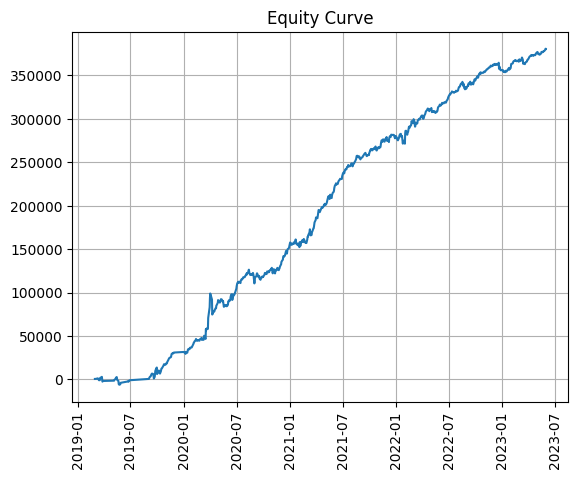

In [ ]:
plt.grid()
plt.xticks(rotation =90)
plt.title('Equity Curve')
plt.plot(pnl['Cum_profit'])

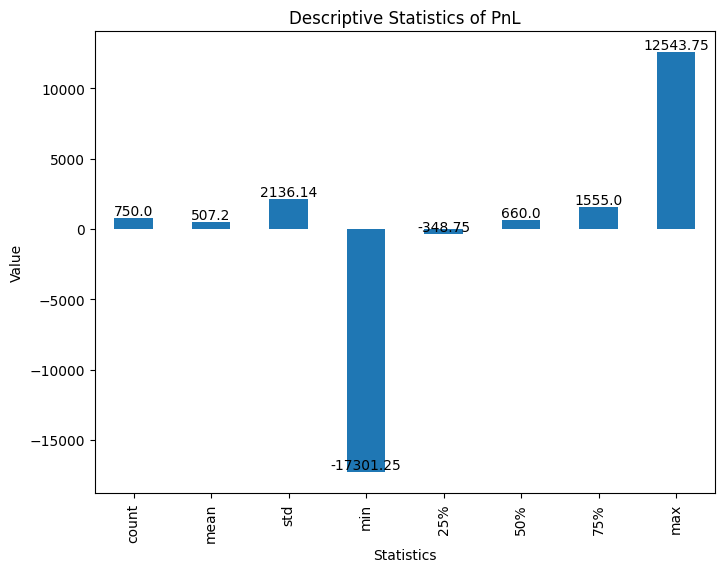

In [ ]:
import matplotlib.pyplot as plt

# Calculate descriptive statistics of the profits
stats = pnl['PnL'].describe()

# Create a bar plot
ax = stats.plot(kind='bar', figsize=(8, 6))

# Add annotations to the bars
for i, v in enumerate(stats):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Set the plot title and axis labels
plt.title('Descriptive Statistics of PnL')
plt.xlabel('Statistics')
plt.ylabel('Value')

# Show the plot
plt.show()

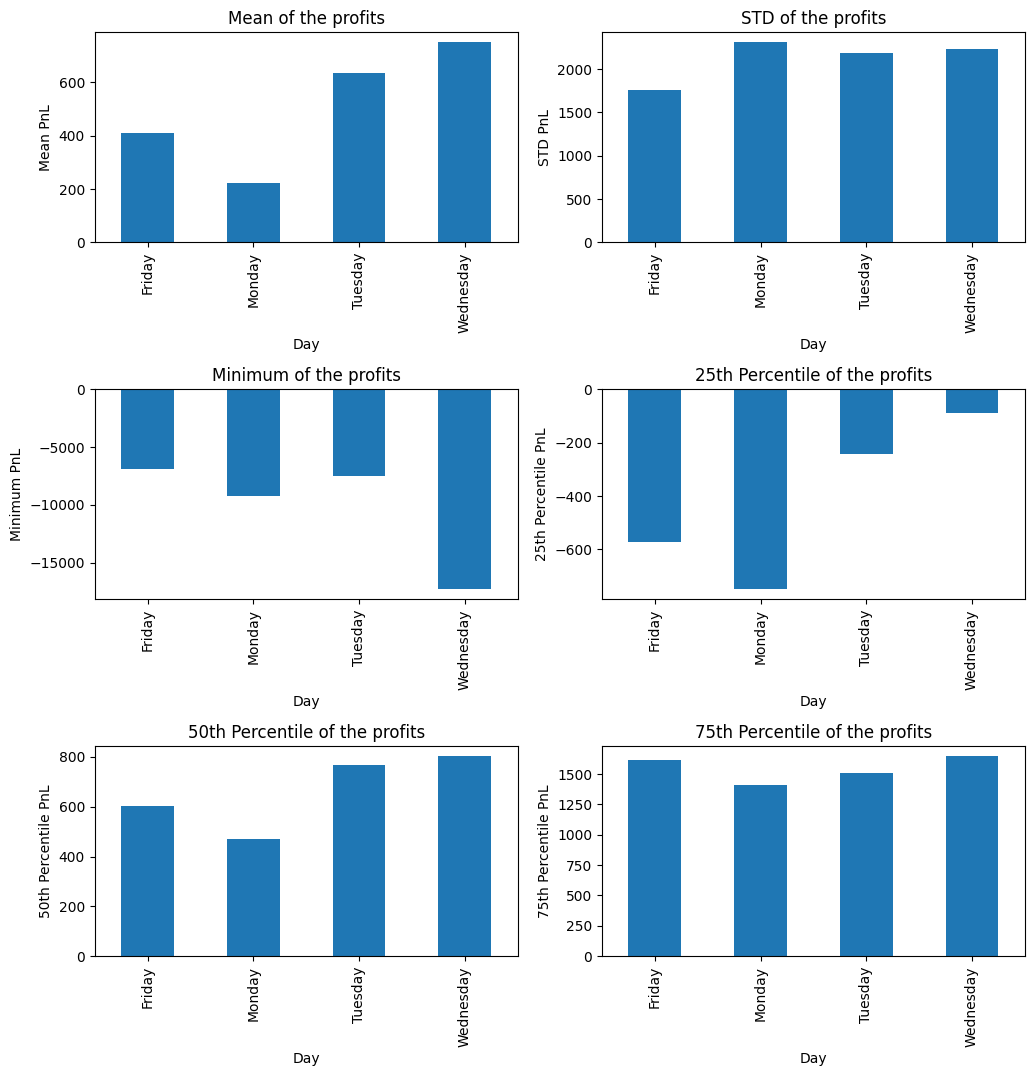

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.7)  # Adjust the vertical spacing between subplots

# Mean of the profits
axes[0, 0].set_title('Mean of the profits')
pnl.groupby('Day')['PnL'].mean().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Mean PnL')

# STD of the profits
axes[0, 1].set_title('STD of the profits')
pnl.groupby('Day')['PnL'].std().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('STD PnL')

# Minimum of the profits
axes[1, 0].set_title('Minimum of the profits')
pnl.groupby('Day')['PnL'].min().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Minimum PnL')

# 25th Percentile of the profits
axes[1, 1].set_title('25th Percentile of the profits')
pnl.groupby('Day')['PnL'].quantile(0.25).plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('25th Percentile PnL')

# 50th Percentile of the profits
axes[2, 0].set_title('50th Percentile of the profits')
pnl.groupby('Day')['PnL'].median().plot(kind='bar', ax=axes[2, 0])
axes[2, 0].set_xlabel('Day')
axes[2, 0].set_ylabel('50th Percentile PnL')

# 75th Percentile of the profits
axes[2, 1].set_title('75th Percentile of the profits')
pnl.groupby('Day')['PnL'].quantile(0.75).plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_xlabel('Day')
axes[2, 1].set_ylabel('75th Percentile PnL')

plt.show()

In [ ]:
profit_monthly_df = pnl.resample('M').sum()

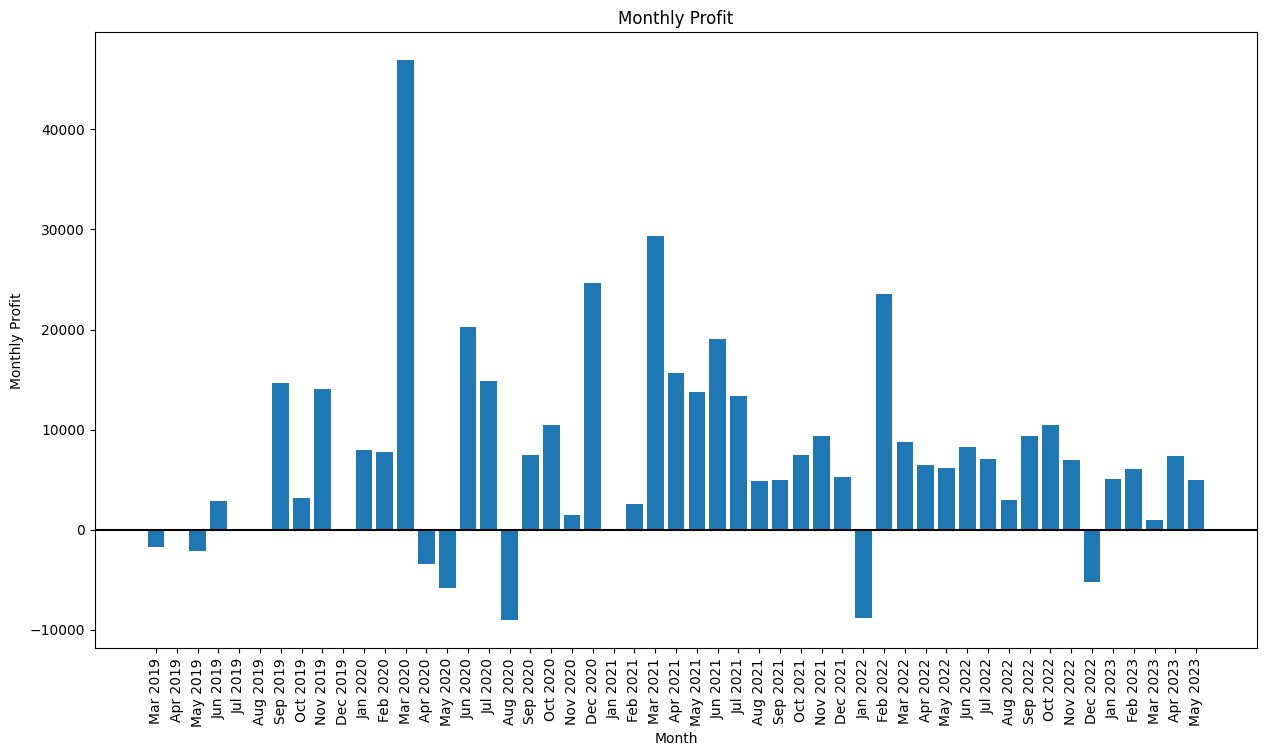

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.bar(range(len(profit_monthly_df['PnL'])), profit_monthly_df['PnL'])
plt.xticks(range(len(profit_monthly_df['PnL'])), profit_monthly_df.index.strftime('%b %Y'), rotation = 90)
plt.axhline(y=0, color = 'black')
plt.xlabel('Month')
plt.ylabel('Monthly Profit')
plt.title('Monthly Profit')
plt.show()

In [ ]:
profit_quarter_df = pnl.resample('q').sum()

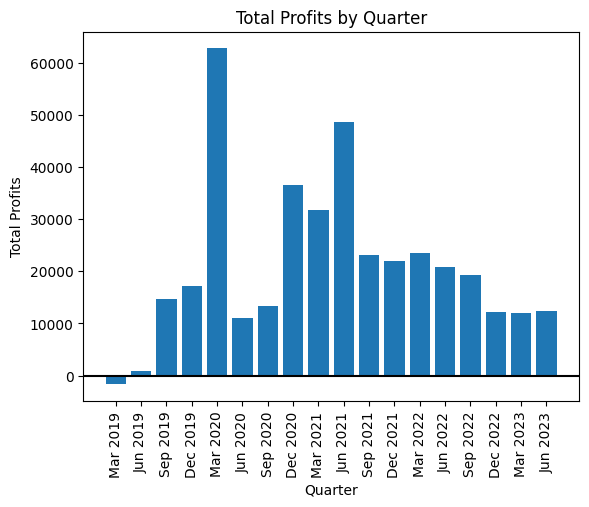

In [ ]:
plt.bar(range(len(profit_quarter_df['PnL'])), profit_quarter_df['PnL'])
plt.xticks(range(len(profit_quarter_df['PnL'])), profit_quarter_df.index.strftime('%b %Y'), rotation = 90)
plt.axhline(y=0, color='black')

plt.xlabel('Quarter')
plt.ylabel('Total Profits')
plt.title('Total Profits by Quarter')
plt.show()

In [ ]:
profit_yearly_df = pnl.resample('Y').sum()

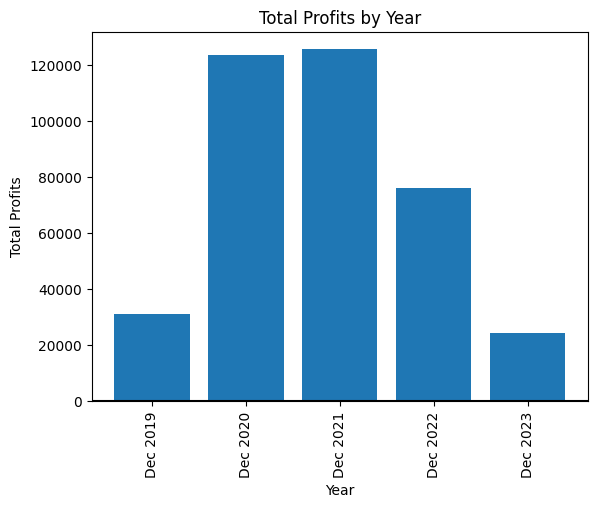

In [ ]:
plt.bar(range(len(profit_yearly_df['PnL'])), profit_yearly_df['PnL'])
plt.xticks(range(len(profit_yearly_df['PnL'])), profit_yearly_df.index.strftime('%b %Y'), rotation = 90)
plt.axhline(y=0, color='black')

plt.xlabel('Year')
plt.ylabel('Total Profits')
plt.title('Total Profits by Year')
plt.show()

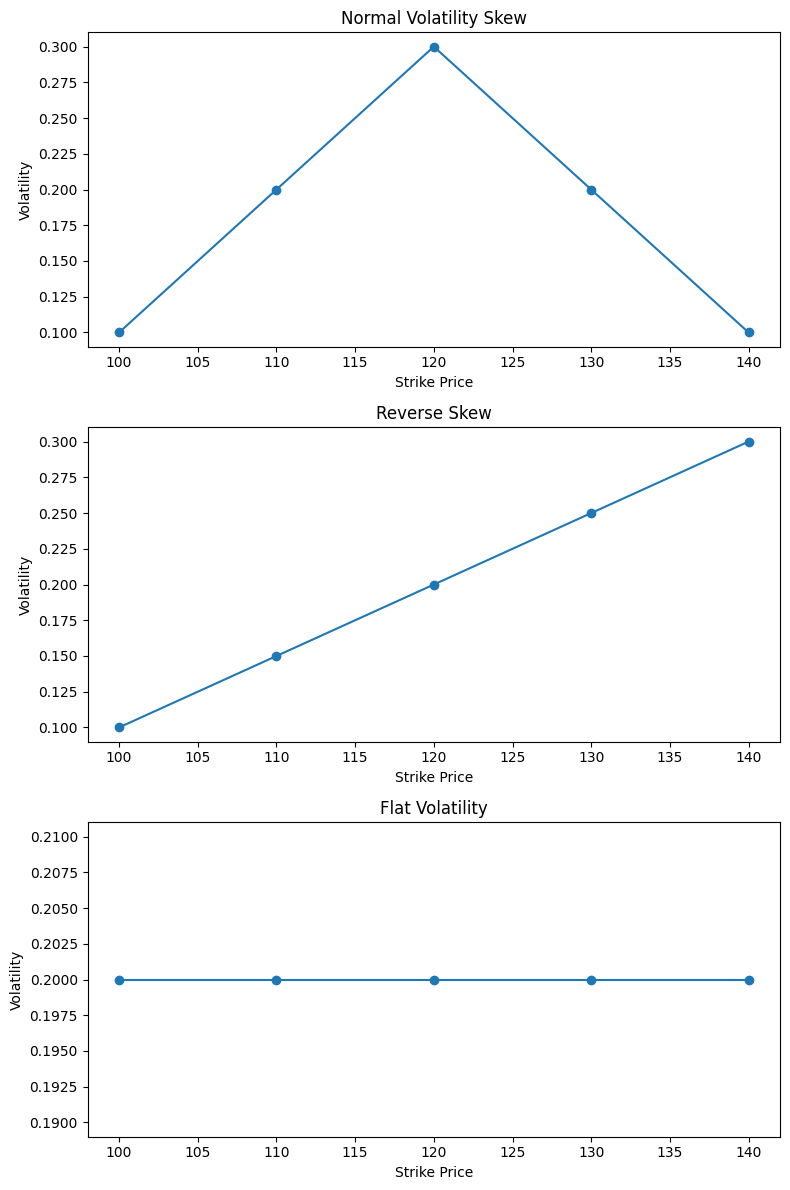

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis values (strike prices)
strike_prices = [100, 110, 120, 130, 140]

# Define the y-axis values for each volatility scenario
normal_volatility = [0.1, 0.2, 0.3, 0.2, 0.1]
reverse_skew = [0.1, 0.15, 0.2, 0.25, 0.3]
flat_volatility = [0.2, 0.2, 0.2, 0.2, 0.2]

# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot the normal volatility skew
ax1.plot(strike_prices, normal_volatility, marker='o')
ax1.set_title('Normal Volatility Skew')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Volatility')

# Plot the reverse skew
ax2.plot(strike_prices, reverse_skew, marker='o')
ax2.set_title('Reverse Skew')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Volatility')

# Plot the flat volatility
ax3.plot(strike_prices, flat_volatility, marker='o')
ax3.set_title('Flat Volatility')
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Volatility')

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [ ]:
data = ma.get_data("nifty", datetime.date(2023,5,2))
data

In [ ]:
data['expiry_date'] = [symbol[5:12] for symbol in data['symbol']]
data['strike_price'] = [symbol[12:-2] for symbol in data['symbol']]

data

,close,date,high,low,oi,open,symbol,time,volume,expiry_date,strike_price
0,0.8,2023-05-02,1.0,0.5,464950.0,0.65,NIFTY04MAY2315450PE,09:15:00,287801,04MAY23,15450
1,0.9,2023-05-02,1.0,0.75,464950.0,0.8,NIFTY04MAY2315450PE,09:16:00,304400,04MAY23,15450
2,0.85,2023-05-02,0.95,0.85,601050.0,0.9,NIFTY04MAY2315450PE,09:17:00,62200,04MAY23,15450
3,0.8,2023-05-02,0.85,0.8,601050.0,0.85,NIFTY04MAY2315450PE,09:18:00,8650,04MAY23,15450
4,0.8,2023-05-02,0.8,0.8,601050.0,0.8,NIFTY04MAY2315450PE,09:19:00,41850,04MAY23,15450
...,...,...,...,...,...,...,...,...,...,...,...
33393,18145.2,2023-05-02,18145.2,18141.1,nan,18142.35,NIFTY,15:25:00,0,,
33394,18142.0,2023-05-02,18144.95,18141.25,nan,18144.95,NIFTY,15:26:00,0,,
33395,18142.45,2023-05-02,18144.0,18140.75,nan,18143.05,NIFTY,15:27:00,0,,
33396,18136.4,2023-05-02,18143.9,18133.35,nan,18142.25,NIFTY,15:28:00,0,,


#2:00 P.M Straddle



In [ ]:
start_date = datetime.date(2023, 5, 1)
end_date = datetime.date(2023, 6, 1)
current_date = start_date

profit = []
pnl_date = []
trades_journal = []

while current_date <= end_date:
    try:

        trade_open = []
        trade_close = []

        data = ma.get_data("banknifty", current_date)

        data['symbol'] = data['symbol'].astype('string')
        data['expiry_date'] = [symbol[5:12] for symbol in data['symbol']]
        data['strike_price'] = [symbol[12:-2] for symbol in data['symbol']]
        data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
        data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
        data['expiry_date'] = data['expiry_date'].astype('string')
        data['close'] = data['close'].astype('float')

        data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
        data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
        data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
        data_bnf = data_bnf.set_index(data_bnf.Datetime)
        data_bnf = data_bnf['close']
        data_bnf = data_bnf.to_frame()
        data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

        data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
        data['Datetime'] = data['date'] + ' ' + data['time']
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        data = data.set_index(data.Datetime)

        data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
        data = data.join(data_bnf, how='inner')

        data['strike_price'] = data['strike_price'].astype('float')
        data['expiry_date'] = pd.to_datetime(data['expiry_date'] + ' ' + '15:30:00')
        data['time_to_expiry'] = data['expiry_date'] - data.index
        data['time_to_expiry'] = data['time_to_expiry']/timedelta(days = 365)
        data['ATM'] = round(data['bnf_close']/100)*100
        data['CE_PE'] = data['CE_PE'].apply(lambda x : 'p' if x == 'PE' else 'c')

        shift_time = datetime.time(14, 00)
        end_time = datetime.time(15, 00)


        data_straddle = data.loc[shift_time]

        data_straddle = data_straddle[data_straddle['strike_price'] == data_straddle['ATM']]

        straddle_price = data[data['strike_price'] == data_straddle['strike_price'][0]]

        sp = data_straddle[data_straddle['CE_PE']=='c'].strike_price[0]

        trade_open.append([data_straddle[data_straddle['CE_PE']=='c'].close[0], data_straddle[data_straddle['CE_PE']=='p'].close[0], sp, data_straddle.index[0]])

        data_straddle_close = data.loc[end_time]
        data_straddle_close = data_straddle_close[data_straddle_close['strike_price'] == sp]
        trade_close.append([data_straddle_close[data_straddle_close['CE_PE']=='c'].close[0], data_straddle_close[data_straddle_close['CE_PE']=='p'].close[0], sp, data_straddle_close.index[0]])

        profit_df = pd.DataFrame(trade_open)-pd.DataFrame(trade_close)
        profit_df = profit_df.iloc[:,[0,1]]
        profit_df['total'] = profit_df.iloc[:,0] + profit_df.iloc[:,1]

        profit.append(profit_df.total.sum()*25)
        pnl_date.append(current_date)
        trades_journal.append([trade_open, trade_close])

    except Exception as e:

        print("Error occurred for date", current_date)
        pass

    current_date += datetime.timedelta(days=1)

In [ ]:
start_date = datetime.date(2023, 5, 28)
end_date = datetime.date(2023, 6, 19)
current_date = start_date

profit = []
pnl_date = []
trades_journal = []

while current_date <= end_date:
    try:
        trade_open = []
        trade_close = []

        data = ma.get_data("nifty", current_date)

        data['symbol'] = data['symbol'].astype('string')
        data['expiry_date'] = [symbol[5:12] for symbol in data['symbol']]
        data['strike_price'] = [symbol[12:-2] for symbol in data['symbol']]
        data['Datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
        data['CE_PE'] = [symbol[-2:] for symbol in data['symbol']]
        data['expiry_date'] = data['expiry_date'].astype('string')
        data['close'] = data['close'].astype('float')

        data_bnf = data[data['expiry_date'] == data['expiry_date'].value_counts().index[2]]
        data_bnf['Datetime'] = data_bnf['date'] + ' ' + data_bnf['time']
        data_bnf['Datetime'] = pd.to_datetime(data_bnf['Datetime'])
        data_bnf = data_bnf.set_index(data_bnf.Datetime)
        data_bnf = data_bnf['close']
        data_bnf = data_bnf.to_frame()
        data_bnf = data_bnf.rename(columns={'close': 'bnf_close'})

        data = data[data['expiry_date'] == data['expiry_date'].value_counts().index[0]]
        data['Datetime'] = data['date'] + ' ' + data['time']
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        data = data.set_index(data.Datetime)

        data = data[['close', 'expiry_date', 'strike_price', 'CE_PE']]
        data = data.join(data_bnf, how='inner')

        data['strike_price'] = data['strike_price'].astype('float')
        data['expiry_date'] = pd.to_datetime(data['expiry_date'] + ' ' + '15:30:00')
        data['time_to_expiry'] = data['expiry_date'] - data.index
        data['time_to_expiry'] = data['time_to_expiry']/timedelta(days = 365)
        data['ATM'] = round(data['bnf_close']/100)*100
        data['CE_PE'] = data['CE_PE'].apply(lambda x : 'p' if x == 'PE' else 'c')

        shift_time = datetime.time(14, 30)
        end_time = datetime.time(15, 00)


        data_straddle = data.loc[shift_time]

        data_straddle = data_straddle[data_straddle['strike_price'] == data_straddle['ATM']]
        sp = data_straddle[data_straddle['CE_PE']=='c'].strike_price[0]

        price_df = data.loc[data.index.time >= shift_time]
        price_df['Day'] = price_df.index.day_name()
        price_df = price_df[price_df['Day'] == 'Thursday']
        price_df = price_df[price_df['strike_price'] == sp]
        price_df['lag1'] = price_df.close.shift()
        price_df['straddle_premium'] = price_df['close'] + price_df['lag1']

        max_straddle_premium = price_df['straddle_premium'].max()
        min_straddle_premium = price_df['straddle_premium'].max()

        max_straddle_premium_index = price_df['straddle_premium'].idxmax()

        trades_journal.append([max_straddle_premium_index, max_straddle_premium, data_straddle.close.sum()])
        print(trades_journal[-1])
    except Exception as e:

        #print(e)
        pass

    current_date += datetime.timedelta(days=1)

In [ ]:
trades_journal

[]

In [ ]:
trades_data = pd.DataFrame(trades_journal, columns = ['High DateTime', 'High', '2:30 PM premium'])
# trades_data.index = pd.to_datetime(trades_data.index)
# trades_data['Day'] = trades_data.index.day_name()
# trades_data = trades_data[trades_data['Day'] == 'Thursday']
trades_data.to_csv('trades_data_2pm_straddle.csv')